In [2]:
import gpt4free
import re
import requests
from pynterface import Ellipsis, smooth_print, Color
from bs4 import BeautifulSoup
from gpt4free import Provider
import matplotlib.pyplot as plt
import numpy as np

PAGE_COUNT = 49
SEARCH_TERM = "genetically modified organisms effects on the world"
GET_SOUP = lambda url: BeautifulSoup(requests.get(url).text, "html.parser")
PROGRESS_FREQUENCY = 8

Web scrape and obtain the abstracts for analysis, saved in a file.

In [ ]:
with open("abstracts.txt", "w") as f:

    """ This part obtains the article id's to parse through, given a search term """

    # in case of errors near the end
    try:        
        with Ellipsis(message="Getting Article ID's"):

            article_ids = []
            search_url = f"https://pubmed.ncbi.nlm.nih.gov/?term={SEARCH_TERM.replace(' ', '%20')}&page="

            for page in range(1, PAGE_COUNT):
                soup = GET_SOUP(f"{search_url}{page}")
                for link in soup.find_all("a", {"class": "docsum-title"}):
                    article_ids.append(link.attrs["data-article-id"])
            
    except Exception as e: 
        print(e)        

    """ This part obtainas abstracts from the articles """

    with Ellipsis(message="Getting Abstracts") as loader:

        abstracts = []
        article_url = "https://pubmed.ncbi.nlm.nih.gov/"

        for index, id in enumerate(article_ids, start=1):
            soup = GET_SOUP(f"{article_url}{id}")
            if index % PROGRESS_FREQUENCY == 0:
                loader.print_above(f"{Color.BLUE}{index} {Color.RESET_COLOR}abstracts read.")
            try: 
                abstract = soup.find("div", {"class": "abstract-content"}).text
                abstract = abstract.strip().replace("\n", ' ')      # remove trailing and sub spaces for newlines between
                abstracts.append(abstract+"\n") 
            except:
                loader.print_above(f"{Color.RED}ERROR: {Color.RESET_COLOR}Article with ID {Color.BLUE}{id} {Color.RESET_COLOR}has no abstract.")

    # write to file
    f.writelines(abstracts)
    smooth_print("Successfully saved abstracts.")

Obtain the AI analysis of the abstracts.

In [3]:
def analyze_abstract(abstract):

    prompt = """Analyze the text to determine the effects of genetically modified organisms on the environment, the economy, and health. Your output should be in the following format: "environment: <response>, economy: <response>, health: <response>", where <response> can be 'G' for good, 'B' for bad, 'N' for neutral, or 'I' for not enough information."""
    response = "Unable to fetch the response, Please try again."

    # filter bad responses
    while "Unable to fetch the response, Please try again." in response:
        response = gpt4free.Completion.create(Provider.You, prompt=abstract+"\n"+prompt)

    response = response.lower()
        
    # get information
    try: env = re.search("environment: [a-z]", response).group().split()[1]
    except: env = None
    try: econ = re.search("economy: [a-z]", response).group().split()[1]
    except: econ = None
    try: health = re.search("health: [a-z]", response).group().split()[1]
    except: health = None
    
    return {"environment": env, "economy": econ, "health": health}

with open("abstracts.txt", "r") as f:
    abstracts = f.readlines()

data = {
    "environment": [],
    "economy": [],
    "health": [],
}

# analyze each abstract using the AI
with Ellipsis("Analyzing") as loader:
    for index, abstract in enumerate(abstracts, start=1):
        if not index % 5:
            loader.print_above(f"{index} articles analyzed.")
        response = analyze_abstract(abstract)
        for topic, effect in response.items():
            if effect == None:
                continue
            data[topic].append(effect)

5 articles analyzed.
10 articles analyzed.
       

Plot the results.

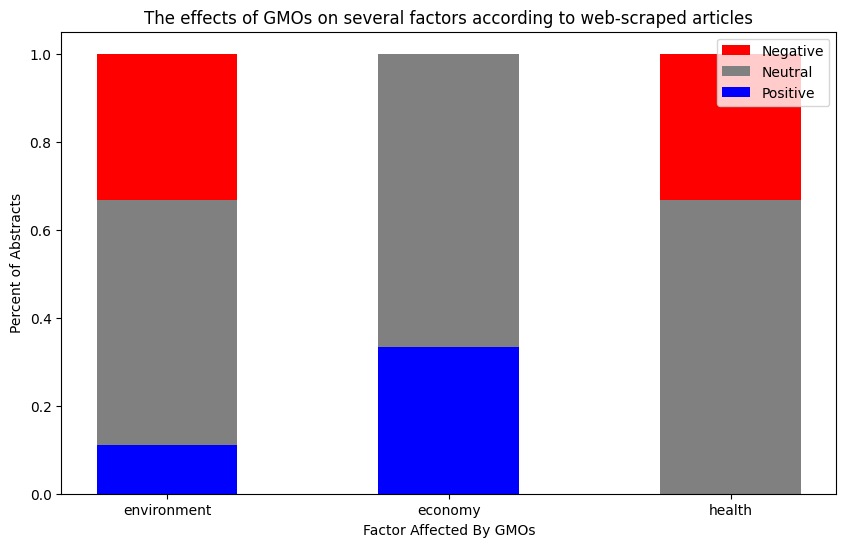

In [9]:
env_cnt = len(data["environment"])
env_good = data["environment"].count('g') / env_cnt
env_bad = data["environment"].count('b') / env_cnt
env_mid = 1 - env_good - env_bad

econ_cnt = len(data["economy"])
econ_good = data["economy"].count('g') / econ_cnt
econ_bad = data["economy"].count('b') / econ_cnt
econ_mid = 1 - econ_good - econ_bad

health_cnt = len(data["health"])
health_good = data["health"].count('g') / health_cnt
health_bad = data["health"].count('b') / health_cnt
health_mid = 1 - health_good - health_bad

# plot graphs
stat_count = 3  # health, econ, env
x_size, y_size = 10, 6
fig = plt.figure(figsize=(x_size, y_size))
bar_width = x_size / stat_count / 2

# determines x-axis
x_axis = np.arange(0, x_size, x_size / stat_count)

# for stacking
goods = [env_good, econ_good, health_good]
mids = [env_good+env_mid, econ_good+econ_mid, health_good+health_mid]
bads = [1, 1, 1]

# plots bars
plt.bar(x_axis, bads, bar_width, color="red", label="Negative")
plt.bar(x_axis, mids, bar_width, color="gray", label="Neutral")
plt.bar(x_axis, goods, bar_width, color="blue", label="Positive")

# labels
plt.xticks(x_axis, data.keys(), fontsize=10)    
plt.xlabel("Factor Affected By GMOs")
plt.ylabel("Percent of Abstracts")
plt.title(f"The effects of GMOs on several factors according to web-scraped articles")

# shows figure
plt.legend(loc="best")
plt.savefig(f"result.png")
plt.show()